In [10]:
import numpy as np
import pandas as pd
import yaml
import torch
import scanpy as sc
import scvi
import scib 

from scib_metrics.benchmark import Benchmarker

from copy import deepcopy
import matplotlib.pyplot as plt
from celldreamer.eval.eval_utils import normalize_and_compute_metrics

from celldreamer.paths import DATA_DIR

from celldreamer.models.fm.ode import torch_wrapper
from tqdm import tqdm 
from pathlib import Path

device  = "cuda" if torch.cuda.is_available() else "cpu"

sc.set_figure_params(dpi=100, frameon=False, fontsize=12)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [11]:
adata = sc.read_h5ad(DATA_DIR / 'processed_full_genome' / 'neurips' / 'neurips_train.h5ad')

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


# scVI

In [12]:
scvi.model.SCVI.setup_anndata(adata, layer="X_counts", batch_key="Site")

In [13]:
# model = scvi.model.SCVI(adata, n_layers=2, n_latent=50, gene_likelihood="nb")

In [14]:
# model.train()

In [15]:
model = scvi.model.SCVI.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scvi_model_neurips/",
                             adata)

INFO     File                                                                                                      
         /home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scvi_mod
         el_neurips/model.pt already downloaded                                                                    


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
  rank_zero_warn(


In [16]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()

In [17]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)

In [18]:
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


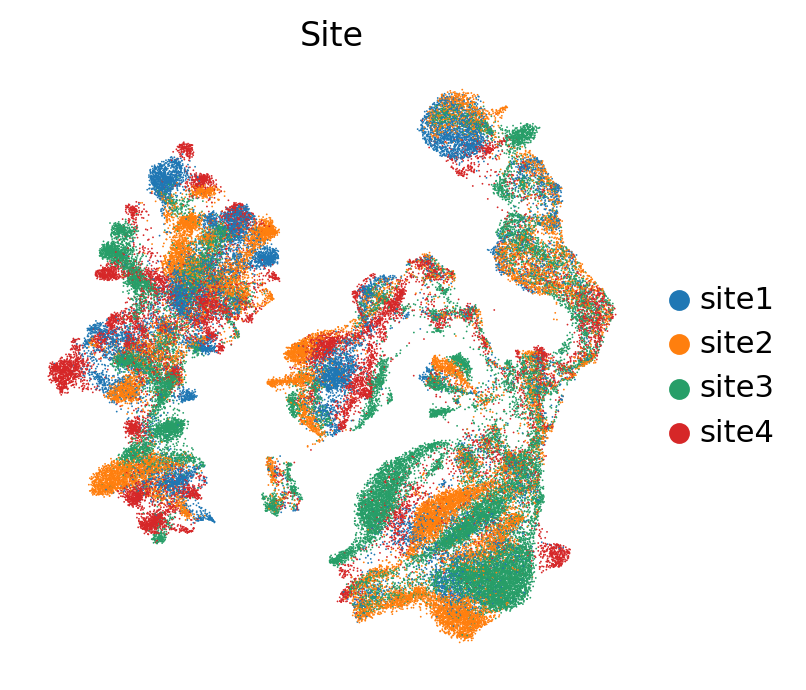

In [19]:
sc.pl.umap(adata, color="Site")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


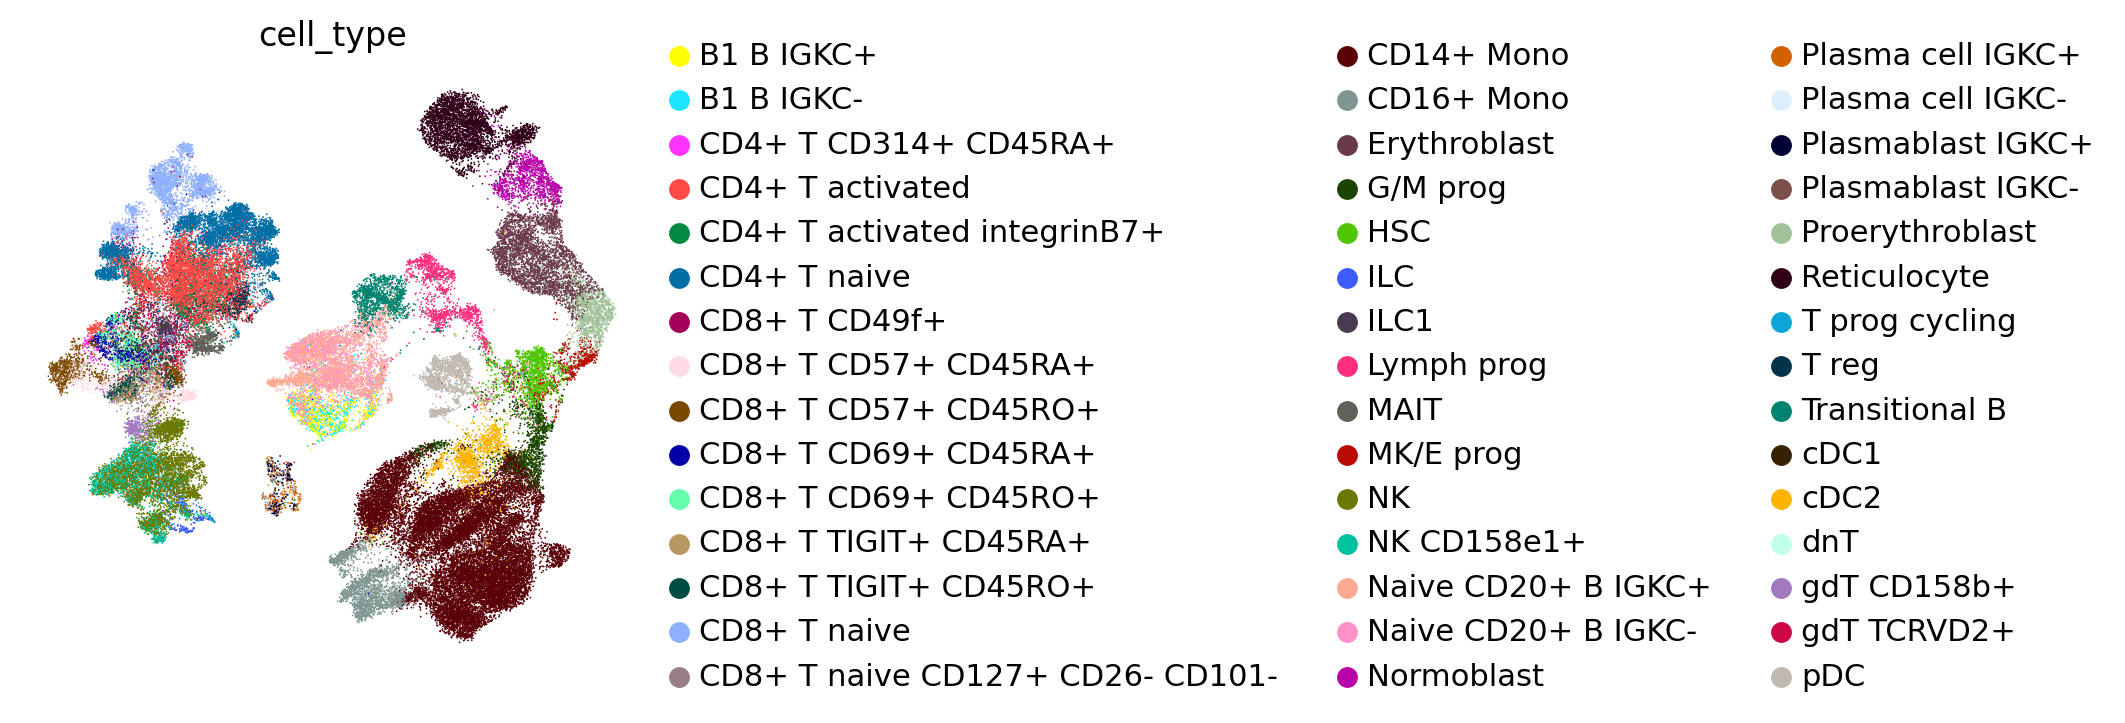

In [20]:
sc.pl.umap(adata, color="cell_type")

# scanVI

In [21]:
# scanvi_model = scvi.model.SCANVI.from_scvi_model(
#     model,
#     adata=adata,
#     labels_key="cell_type",
#     unlabeled_category="Unknown"
# )

In [22]:
# scanvi_model.train(max_epochs=20, n_samples_per_label=100)

In [28]:
scanvi_model = scvi.model.SCANVI.load("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scanvi_model_neurips",
                             adata)

INFO     File                                                                                                      
         /home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scanvi_m
         odel_neurips/model.pt already downloaded                                                                  


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:168: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/icb/alessandro.palma/miniconda3/envs/celldream ...
  rank_zero_warn(


In [29]:
SCANVI_LATENT_KEY = "X_scANVI"
adata.obsm[SCANVI_LATENT_KEY] = scanvi_model.get_latent_representation(adata)

In [30]:
sc.pp.neighbors(adata, use_rep=SCANVI_LATENT_KEY)

In [31]:
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


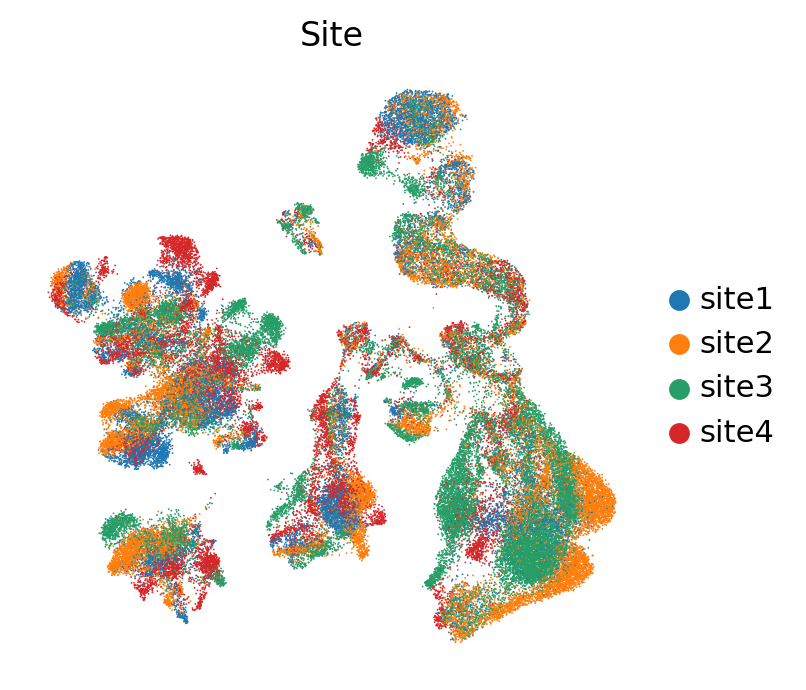

In [32]:
sc.pl.umap(adata, color="Site")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


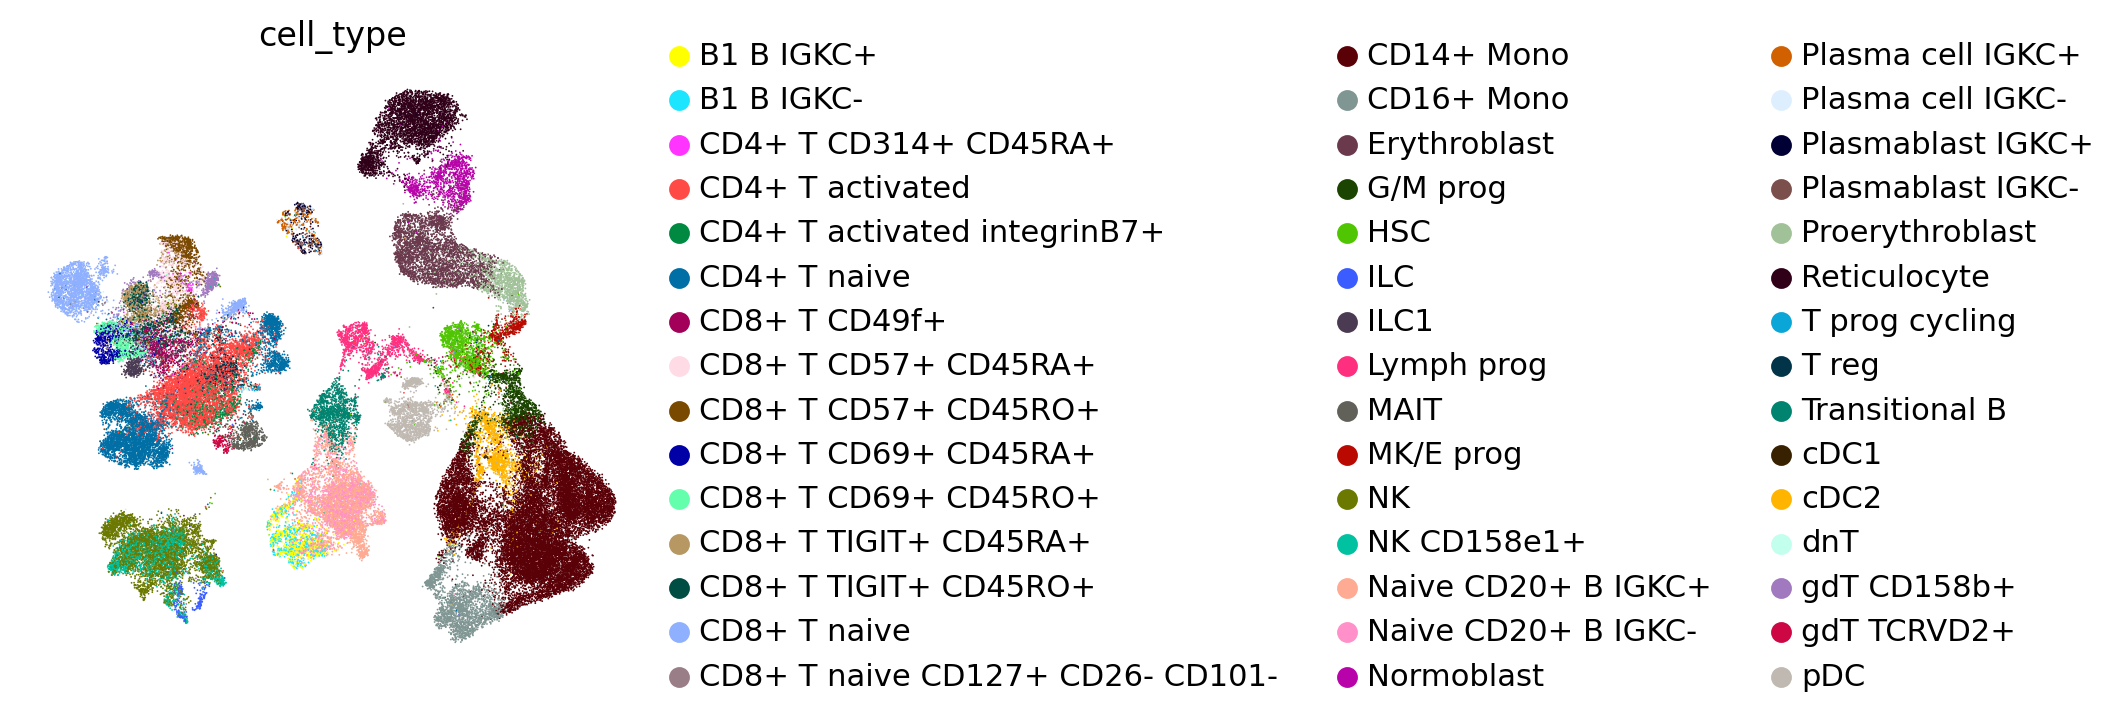

In [33]:
sc.pl.umap(adata, color="cell_type")

In [211]:
# model.save("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scvi_model_neurips")
# scanvi_model.save("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/scanvi_model_neurips")

# Read cellFlow corrected dataset

In [212]:
adata_corrected_cellflow = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/neurips_batch_correction/adata_corrected.h5ad")

In [213]:
adata_corrected_decoded_cellflow = sc.read_h5ad("/home/icb/alessandro.palma/environment/cfgen/project_folder/datasets/generated/neurips_batch_correction/adata_corrected_decoded.h5ad")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


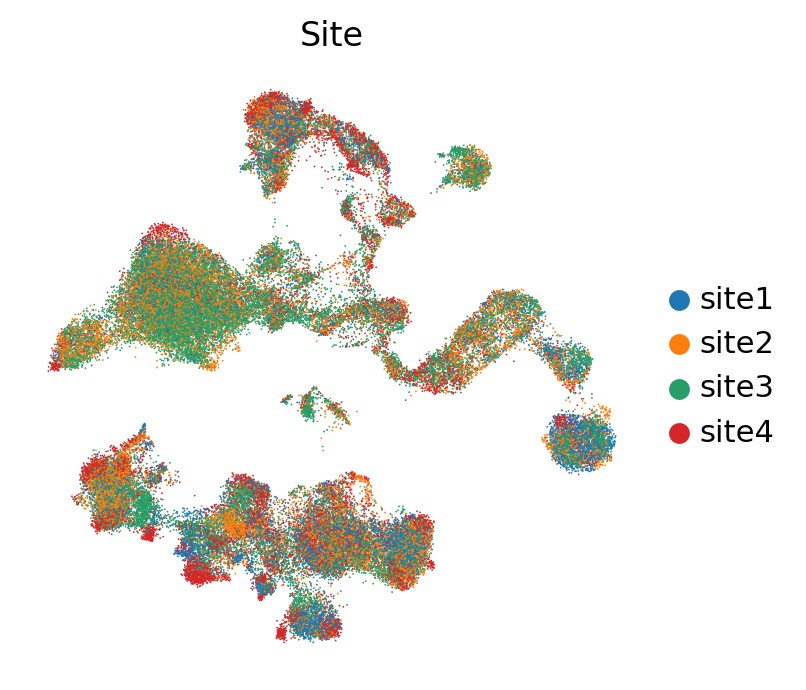

In [214]:
sc.pl.umap(adata_corrected_cellflow, color="Site")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


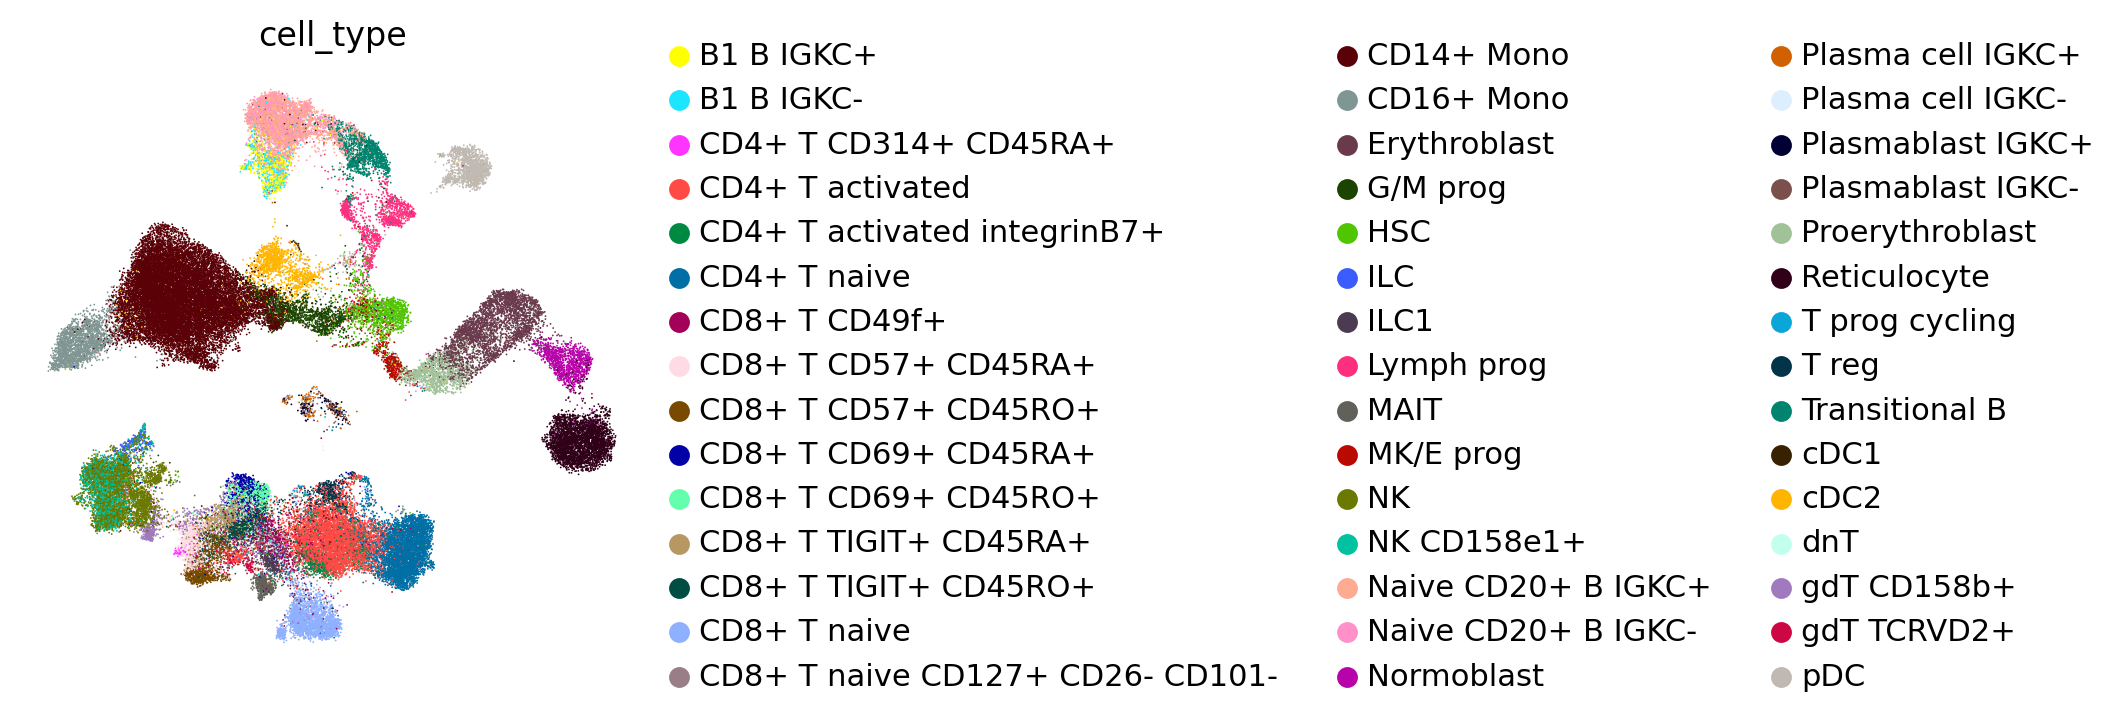

In [215]:
sc.pl.umap(adata_corrected_cellflow, color="cell_type")

In [216]:
adata.obsm["X_cellFlow"] = adata_corrected_cellflow.X.copy()

# Compute metrics

In [217]:
bm = Benchmarker(
    adata,
    batch_key="Site",
    label_key="cell_type",
    embedding_obsm_keys=["X_pca", SCVI_LATENT_KEY, SCANVI_LATENT_KEY,"X_cellFlow"],
    n_jobs=-1,
)
bm.benchmark()

Metrics:  60%|██████    | 6/10 [05:30<02:10, 32.68s/it, Batch correction: kbet_per_label]/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4+ T CD314+ CD45RA+ consists of a single batch or is too small. Skip.                                   


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     CD8+ T naive CD127+ CD26- CD101- consists of a single batch or is too small. Skip.                        


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     T prog cycling consists of a single batch or is too small. Skip.                                          


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     cDC1 consists of a single batch or is too small. Skip.                                                    


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     CD4+ T CD314+ CD45RA+ consists of a single batch or is too small. Skip.                                   


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     CD8+ T naive CD127+ CD26- CD101- consists of a single batch or is too small. Skip.                        


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     T prog cycling consists of a single batch or is too small. Skip.                                          


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     cDC1 consists of a single batch or is too small. Skip.                                                    


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)

Metrics:  70%|███████   | 7/10 [05:55<01:49, 36.52s/it, Batch correction: graph_connectivity]/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3

INFO     CD4+ T CD314+ CD45RA+ consists of a single batch or is too small. Skip.                                   


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     CD8+ T naive CD127+ CD26- CD101- consists of a single batch or is too small. Skip.                        


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     T prog cycling consists of a single batch or is too small. Skip.                                          


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     cDC1 consists of a single batch or is too small. Skip.                                                    


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)

Metrics:  70%|███████   | 7/10 [06:03<01:45, 35.25s/it, Batch correction: graph_connectivity]/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3

INFO     CD4+ T CD314+ CD45RA+ consists of a single batch or is too small. Skip.                                   


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     CD8+ T naive CD127+ CD26- CD101- consists of a single batch or is too small. Skip.                        


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

INFO     T prog cycling consists of a single batch or is too small. Skip.                                          


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     cDC1 consists of a single batch or is too small. Skip.                                                    


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated 

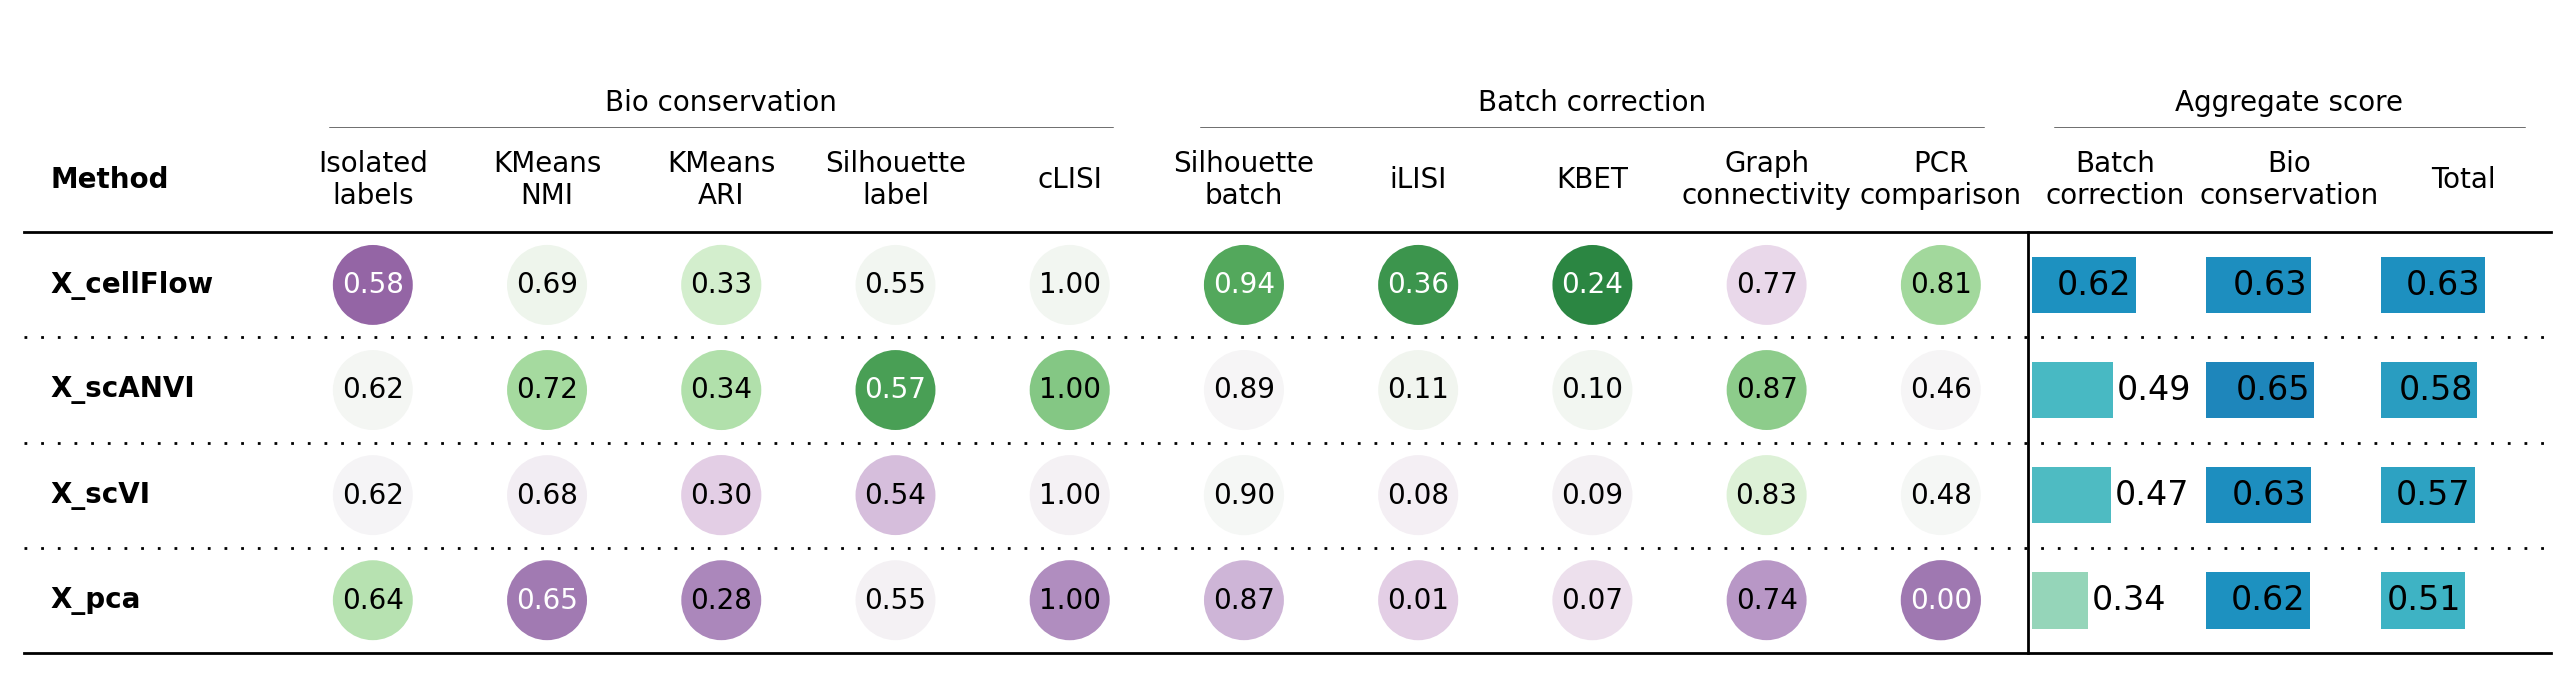

In [35]:
bm.plot_results_table(min_max_scale=False)

In [34]:
import pickle as pkl 

# with open("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/results_integration.pkl", "wb") as file:
#     pkl.dump(bm, file)

with open("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/results_integration.pkl", "rb") as file:
    bm = pkl.load(file)

In [225]:
# df = bm.get_results(min_max_scale=False)
# df.to_csv("/home/icb/alessandro.palma/environment/cfgen/project_folder/baseline_experiments/batch_correction/results_integration.csv")

# Try and get normalized counts by scvi

In [219]:
from scvi.distributions import NegativeBinomial

In [220]:
def get_transformed_counts_scvi(scvi_model, scvi_adata, batch_key):
    scvi_transformed = scvi_model.get_normalized_expression(transform_batch=batch_key)
    scaled_counts = torch.tensor(np.array(scvi_transformed*scvi_adata.layers["X_counts"].sum(1))).cuda()
    inverse_disp = torch.exp(scvi_model.module.px_r).cuda()
    dist = NegativeBinomial(mu=scaled_counts, theta=inverse_disp)
    sampled_cells = dist.sample()
    adata_corrected_scvi = sc.AnnData(X=sampled_cells.cpu().numpy(),
                                         obs=scvi_adata.obs)
    adata_corrected_scvi.layers["X_counts"] = adata_corrected_scvi.X.copy()
    sc.pp.normalize_total(adata_corrected_scvi, 1e4)
    sc.pp.log1p(adata_corrected_scvi)
    sc.tl.pca(adata_corrected_scvi)
    sc.pp.neighbors(adata_corrected_scvi)
    sc.tl.umap(adata_corrected_scvi)
    return adata_corrected_scvi

In [221]:
sampled_cells = get_transformed_counts_scvi(model, adata, "site4")

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.79 GiB. GPU 0 has a total capacty of 19.50 GiB of which 1.25 GiB is free. Process 2131457 has 12.05 GiB memory in use. Including non-PyTorch memory, this process has 6.15 GiB memory in use. Process 3252160 has 3.36 GiB memory in use. Of the allocated memory 5.84 GiB is allocated by PyTorch, and 95.55 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
sc.pl.umap(sampled_cells, color="Site")

In [ ]:
sc.pl.umap(adata_corrected_decoded_cellflow, color="Site")

# Overlay on real data

In [ ]:
merged_X = np.concatenate([sampled_cells.X, 
                           adata_corrected_decoded_cellflow.X], axis=0)

In [ ]:
labs = {"model": ["scVI" for _ in range(sampled_cells.X.shape[0])] + ["cellFlow" for _ in range(adata_corrected_decoded_cellflow.X.shape[0])]}

In [ ]:
merged_adata = sc.AnnData(merged_X,
                         obs=pd.DataFrame(labs))
sc.tl.pca(merged_adata)
sc.pp.neighbors(merged_adata)
sc.tl.umap(merged_adata)

In [ ]:
sc.pl.umap(merged_adata, color="model")